# Crime since 2001 in Chicago

* Data source: [data.gov](https://catalog.data.gov/dataset/crimes-2001-to-present-398a4)


* Describe the dataset:

    This dataset reflects reported incidents of crime that occurred in the City of Chicago from 2001 to August 9, 2018, minus the most recent seven days.

    Columns in the dataset: ['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type', 'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat', 'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate', 'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude', 'Location']


* Outline the types of insights you hope to gain from it:

    1. Most common type of crime each year and each date in Chicago.
    1. The changes of crime over time in Chicago.
    1. 


* Make hypotheses about what you might find:

    1. According to [this website](https://www.criminaljusticedegreehub.com/what-are-the-most-common-crimes-in-the-united-states/), theft should be the most common type of crimes.
    1. A lot of crimes that were categorized as [Battery](https://en.wikipedia.org/wiki/Battery_(crime) type occurred during Black Friday.
    1. Most of the crimes happened in [these neighborhoods](https://www.roadsnacks.net/these-are-the-10-worst-chicago-neighborhoods/).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pyspark.sql.types import *
from pyspark.sql.functions import *
from datetime import datetime
import time

In [11]:
%%time

df = spark.read.format('csv')\
    .option('header', 'true')\
    .load('hdfs://orion11:13030/crime-since-2001-chicago.csv')
df.show(5)

+--------+-----------+--------------------+--------------------+----+-------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|                Date|               Block|IUCR| Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+--------------------+--------------------+----+-------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|10000092|   HY189866|03/18/2015 07:44:...|     047XX W OHIO ST|041A|      BATTERY| AGGRAVATED: HANDGUN|              STREET| false|   false|1111

In [3]:
df.columns

['ID',
 'Case Number',
 'Date',
 'Block',
 'IUCR',
 'Primary Type',
 'Description',
 'Location Description',
 'Arrest',
 'Domestic',
 'Beat',
 'District',
 'Ward',
 'Community Area',
 'FBI Code',
 'X Coordinate',
 'Y Coordinate',
 'Year',
 'Updated On',
 'Latitude',
 'Longitude',
 'Location']

## Most common type of crime each year and each date (month-day).

In [10]:
serialize_date = udf(
    lambda d: '{:02d}'.format(datetime.strptime(d, '%m/%d/%Y %I:%M:%S %p').month) + '-' + '{:02d}'.format(datetime.strptime(d, '%m/%d/%Y %I:%M:%S %p').day),
    StringType(),
)

In [12]:
%%time

df = df.withColumn('Date', serialize_date(df['Date']))

df.show(3)

+--------+-----------+-----+--------------------+----+-------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number| Date|               Block|IUCR| Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+-----+--------------------+----+-------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|10000092|   HY189866|03-18|     047XX W OHIO ST|041A|      BATTERY| AGGRAVATED: HANDGUN|              STREET| false|   false|1111|     011|  28|            25|     04B|     1144606|     190

In [15]:
%%time

df.createOrReplaceTempView('crime')
temp = spark.sql(
    '''
    SELECT
        Year,
        `Primary Type`,
        COUNT(`Primary Type`) AS counts
    FROM crime
    GROUP BY Year, `Primary Type`
    '''
)

temp.show(20)

+----+--------------------+------+
|Year|        Primary Type|counts|
+----+--------------------+------+
|2005|            BURGLARY| 25504|
|2010|             ROBBERY| 14274|
|2007|            HOMICIDE|   447|
|2013|        PROSTITUTION|  1652|
|2005|             ROBBERY| 16047|
|2018|           OBSCENITY|    79|
|2001|       OTHER OFFENSE| 29657|
|2016| MOTOR VEHICLE THEFT| 11294|
|2002|   WEAPONS VIOLATION|  4281|
|2007|         SEX OFFENSE|  1528|
|2014|           OBSCENITY|    38|
|2009|           NARCOTICS| 43543|
|2005|     CRIMINAL DAMAGE| 54548|
|2006|OTHER NARCOTIC VI...|     9|
|2003|LIQUOR LAW VIOLATION|  1311|
|2017|        INTIMIDATION|   151|
|2005|        INTIMIDATION|   258|
|2007|           RITUALISM|     1|
|2015|               ARSON|   453|
|2009|   WEAPONS VIOLATION|  4158|
+----+--------------------+------+
only showing top 20 rows

CPU times: user 5.35 ms, sys: 1.25 ms, total: 6.6 ms
Wall time: 4.92 s


In [16]:
%%time

temp.createOrReplaceTempView('temp')
result = spark.sql(
    '''
    SELECT temp.*
    FROM temp,
    (
        SELECT
            Year,
            MAX(counts) AS counts
        FROM temp
        GROUP BY Year
    ) AS max_count
    WHERE temp.year = max_count.year
        AND temp.counts = max_count.counts
    ORDER BY temp.year ASC
    '''
)

result.show()

+----+------------+------+
|Year|Primary Type|counts|
+----+------------+------+
|2001|       THEFT| 99264|
|2002|       THEFT| 98327|
|2003|       THEFT| 98875|
|2004|       THEFT| 95463|
|2005|       THEFT| 85685|
|2006|       THEFT| 86240|
|2007|       THEFT| 85156|
|2008|       THEFT| 88433|
|2009|       THEFT| 80973|
|2010|       THEFT| 76754|
|2011|       THEFT| 75148|
|2012|       THEFT| 75460|
|2013|       THEFT| 71530|
|2014|       THEFT| 61562|
|2015|       THEFT| 57336|
|2016|       THEFT| 61600|
|2017|       THEFT| 64334|
|2018|       THEFT| 58636|
+----+------------+------+

CPU times: user 2.37 ms, sys: 2.53 ms, total: 4.91 ms
Wall time: 5.41 s


* We can see that theft is the most common type of crime through out the time as our hypothesis.

In [17]:
%%time

temp = spark.sql(
    '''
    SELECT
        Date,
        `Primary Type`,
        COUNT(`Primary Type`) AS counts
    FROM crime
    GROUP BY Date, `Primary Type`
    '''
)

temp.show(20)

+-----+--------------------+------+
| Date|        Primary Type|counts|
+-----+--------------------+------+
|11-18| MOTOR VEHICLE THEFT|   884|
|04-04|            BURGLARY|   946|
|10-21|        PROSTITUTION|   227|
|09-23|            STALKING|    13|
|12-02|           NARCOTICS|  1965|
|04-24|   CRIMINAL TRESPASS|   543|
|05-01|INTERFERENCE WITH...|    34|
|12-22|             ROBBERY|   780|
|05-08|           NARCOTICS|  2053|
|05-10|  DECEPTIVE PRACTICE|   752|
|12-31|  DECEPTIVE PRACTICE|   633|
|01-10|             ASSAULT|  1005|
|05-25|           NARCOTICS|  1917|
|02-09|OFFENSE INVOLVING...|   114|
|01-20|        PROSTITUTION|   194|
|01-24|           NARCOTICS|  2282|
|07-12|             ROBBERY|   735|
|07-13|               THEFT|  4556|
|03-11|             BATTERY|  3536|
|03-20|            BURGLARY|   905|
+-----+--------------------+------+
only showing top 20 rows

CPU times: user 5.68 ms, sys: 5.73 ms, total: 11.4 ms
Wall time: 8.09 s


In [18]:
%%time

temp.createOrReplaceTempView('temp')
result = spark.sql(
    '''
    SELECT temp.*
    FROM temp,
    (
        SELECT
            Date,
            MAX(counts) AS counts
        FROM temp
        GROUP BY Date
    ) AS max_count
    WHERE temp.Date = max_count.Date
        AND temp.counts = max_count.counts
    ORDER BY temp.Date ASC
    '''
)

result.show()

+-----+------------+------+
| Date|Primary Type|counts|
+-----+------------+------+
|01-01|       THEFT|  6347|
|01-02|       THEFT|  3300|
|01-03|       THEFT|  3369|
|01-04|       THEFT|  3357|
|01-05|       THEFT|  3399|
|01-06|       THEFT|  3211|
|01-07|       THEFT|  3252|
|01-08|       THEFT|  3288|
|01-09|       THEFT|  3527|
|01-10|       THEFT|  3631|
|01-11|       THEFT|  3505|
|01-12|       THEFT|  3500|
|01-13|       THEFT|  3509|
|01-14|       THEFT|  3338|
|01-15|       THEFT|  3667|
|01-16|       THEFT|  3441|
|01-17|       THEFT|  3505|
|01-18|       THEFT|  3425|
|01-19|       THEFT|  3433|
|01-20|       THEFT|  3514|
+-----+------------+------+
only showing top 20 rows

CPU times: user 39.3 ms, sys: 16.8 ms, total: 56.1 ms
Wall time: 10.8 s


In [20]:
%%time

pandas_df = result.toPandas()

CPU times: user 73.2 ms, sys: 40.9 ms, total: 114 ms
Wall time: 1.09 s


In [21]:
pandas_df

,Date,Primary Type,counts
0,01-01,THEFT,6347
1,01-02,THEFT,3300
2,01-03,THEFT,3369
3,01-04,THEFT,3357
4,01-05,THEFT,3399
5,01-06,THEFT,3211
6,01-07,THEFT,3252
7,01-08,THEFT,3288
8,01-09,THEFT,3527
9,01-10,THEFT,3631


In [22]:
%%time

result_without_theft = pandas_df[pandas_df['Primary Type'] != 'THEFT']

CPU times: user 826 µs, sys: 0 ns, total: 826 µs
Wall time: 766 µs


In [23]:
result_without_theft

,Date,Primary Type,counts
59,02-29,BATTERY,782
63,03-04,BATTERY,3123
70,03-11,BATTERY,3536
72,03-13,BATTERY,3397
75,03-16,BATTERY,3603
76,03-17,BATTERY,3600
77,03-18,BATTERY,3596
80,03-21,BATTERY,3397
90,03-31,BATTERY,3604
104,04-14,BATTERY,3738


* We didn't get the result that Black Friday would be the day of BATTERY.
* Surprisingly, Battery is the most common type of crimes on Fourth of July, Halloween, and **Christmas**!
* Theft and Battery are two most common crime in Chicago.

#### What happened to Christmas?!

In [24]:
%%time

temp = spark.sql(
    '''
    SELECT
        Date,
        `Primary Type`,
        COUNT(`Primary Type`) AS counts
    FROM crime
    WHERE Date = "12-25"
    GROUP BY Date, `Primary Type`
    '''
)

temp.show(20)

+-----+--------------------+------+
| Date|        Primary Type|counts|
+-----+--------------------+------+
|12-25|  DECEPTIVE PRACTICE|   200|
|12-25|PUBLIC PEACE VIOL...|    37|
|12-25|            HOMICIDE|    26|
|12-25|            BURGLARY|   735|
|12-25|   WEAPONS VIOLATION|    49|
|12-25|            STALKING|     3|
|12-25|             ROBBERY|   440|
|12-25|           NARCOTICS|   405|
|12-25|               THEFT|  1552|
|12-25|            GAMBLING|     1|
|12-25|          KIDNAPPING|    34|
|12-25|             ASSAULT|   654|
|12-25|   CRIMINAL TRESPASS|   186|
|12-25|        NON-CRIMINAL|     1|
|12-25|         SEX OFFENSE|    40|
|12-25| CRIM SEXUAL ASSAULT|    44|
|12-25|               ARSON|    22|
|12-25|LIQUOR LAW VIOLATION|     2|
|12-25|             BATTERY|  2779|
|12-25|       OTHER OFFENSE|   726|
+-----+--------------------+------+
only showing top 20 rows

CPU times: user 8.42 ms, sys: 2.8 ms, total: 11.2 ms
Wall time: 9.06 s


In [25]:
%%time

temp_pd = temp.toPandas()

CPU times: user 11.9 ms, sys: 4.14 ms, total: 16.1 ms
Wall time: 7.98 s


In [26]:
temp_pd

,Date,Primary Type,counts
0,12-25,DECEPTIVE PRACTICE,200
1,12-25,PUBLIC PEACE VIOLATION,37
2,12-25,HOMICIDE,26
3,12-25,BURGLARY,735
4,12-25,WEAPONS VIOLATION,49
5,12-25,STALKING,3
6,12-25,ROBBERY,440
7,12-25,NARCOTICS,405
8,12-25,THEFT,1552
9,12-25,GAMBLING,1


In [30]:
temp_pd.set_index(['counts'])
temp_pd.sort_values('counts', inplace=True, ascending=False)
temp_pd

,Date,Primary Type,counts
18,12-25,BATTERY,2779
8,12-25,THEFT,1552
23,12-25,CRIMINAL DAMAGE,1441
3,12-25,BURGLARY,735
19,12-25,OTHER OFFENSE,726
11,12-25,ASSAULT,654
21,12-25,MOTOR VEHICLE THEFT,585
6,12-25,ROBBERY,440
7,12-25,NARCOTICS,405
0,12-25,DECEPTIVE PRACTICE,200


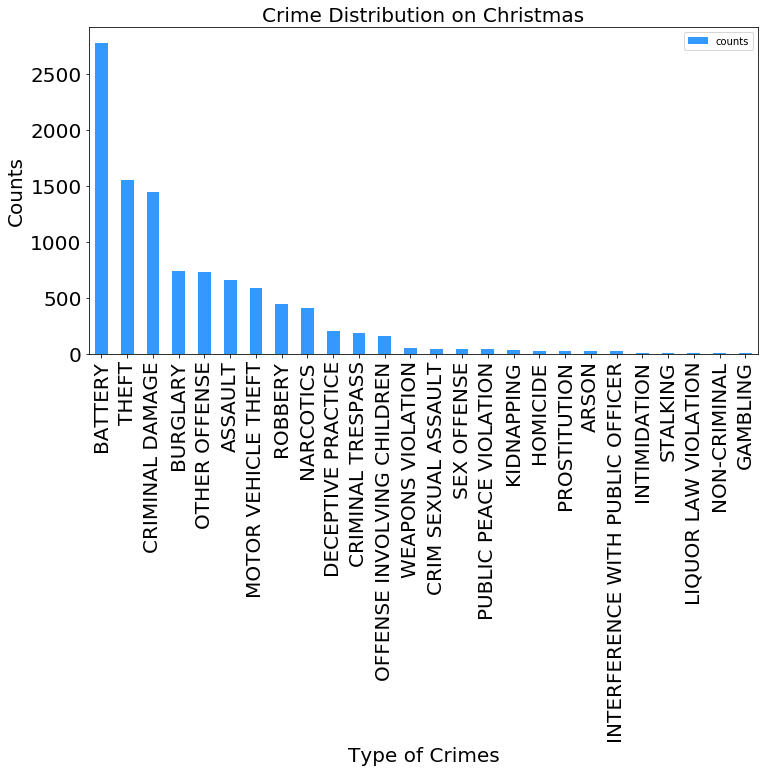

In [31]:
%matplotlib inline

ax = temp_pd.plot(
    kind='bar',
    figsize=(12, 6),
    x='Primary Type',
    y='counts',
    fontsize = 20,
    color='#3399ff',
)
ax.set_xlabel('Type of Crimes', fontsize = 20)
ax.set_ylabel('Counts', fontsize = 20)
ax.set_title('Crime Distribution on Christmas', fontsize = 20)
plt.show()

* 1 Gambling on Christmas! lol